In [1]:
!pip install arabic-reshaper
!pip install python-bidi
!pip install nltk
!pip install openpyxl
!pip install transformers camel-tools

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/9.4 MB 7.4 MB/s eta 0:00:02
   ------------ --------------------------- 2.9/9.4 MB 7.6 MB/s eta 0:00:01
   --------------------- ------------------ 5.0/9.4 MB 8.4 MB/s eta 0:00:01
   ------------------------- -------------- 6.0/9.4 MB 9.0 MB/s eta 0:00:01
   ---------------------------------------- 9.4/9.4 MB 9.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------------------------- -- 2.1/2.2 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 11.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/590.6 kB ? eta -:--:--
   ---------------------------------------- 590.6/590.6 kB 4.2 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size

In [3]:
!pip install wordcloud

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import tqdm
import re
import string
import arabic_reshaper
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForTokenClassification, pipeline
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\02rad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\02rad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# Load file

In [ ]:

file_path = "Tamer_Hosny_Data.xlsx"
df = pd.read_csv(file_path)

# Display the first few rows to inspect the structure
df.head()


,Title,Song ID,URL,Lyrics,Duration,Lyricist,Composer,Distribution
0,100 Wesh - ١٠٠ وش,3852502,https://genius.com/Tamer-hosny-100-wesh-lyrics,أعزائي الغدارين\nأعزائي الغدارين، اللي غدروا ب...,05:35,تامر حسني,تامر حسني,أحمد عادل
1,180 Darga - ١٨٠ درجة,8817979,https://genius.com/Tamer-hosny-180-darga-lyrics,لو راجعة عشان تبعدي بيني وبينها إستني\nدي خدت ...,05:08,محمد عاطف,رامي جمال,أحمد إبراهيم
2,3reft Elly Feha - عرفت اللي فيها,8801064,https://genius.com/Tamer-hosny-3reft-elly-feha...,‫\n\nعرفت اللي فيها\nعينيه بان عليها\nيا قلبي ...,03:56,نادر عبدالله,تامر علي,تميم
3,Aarrab Kaman - قرب كمان,8908305,https://genius.com/Tamer-hosny-aarrab-kaman-ly...,وأنا جنبك حبيبي بجد مش عارف أقولك إيه\nمعاك ال...,04:01,عبير الرزاز,علي شعبان,تميم
4,Ad El Foraq - قد الفراق,8817917,https://genius.com/Tamer-hosny-ad-el-foraq-lyrics,قد الفراق\nقد الفراق اللي إنت جاي بتطلبه\nقد ا...,05:09,تامر حسين,إسلام زكي,إسلام زكي


# Processing

# ------------------------------------------------------------
# Clean Arabic Text
# ------------------------------------------------------------

In [ ]:
def clean_arabic_text_advanced(text):
    if pd.isna(text):
        return ""

    # Remove tashkeel
    text = re.sub(r"[ًٌٍَُِّْ]", "", text)

    # Remove brackets and their content
    text = re.sub(r"\[.*?\]", "", text)

    # Normalize letters
    text = re.sub(r"[أإآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ة", "ه", text)

    # Remove Arabic and English punctuation
    arabic_punct = "؟،؛«»"
    all_punct = string.punctuation + arabic_punct + "؟"
    text = re.sub(f"[{re.escape(all_punct)}]", "", text)

    # Remove numbers
    text = re.sub(r"[0-9٠-٩]", "", text)

    # Remove extra whitespace and newlines
    text = re.sub(r"\s+", " ", text).strip()

    return text

# ------------------------------------------------------------
# Tokenize
# ------------------------------------------------------------

In [ ]:
arabic_stopwords = set(stopwords.words('arabic'))
def tokenize_and_remove_stopwords(text):
    # Simple Arabic word tokenizer (regex split)
    tokens = re.findall(r"\b\w+\b", text)
    tokens = [token for token in tokens if token not in arabic_stopwords and token.strip() != ""]
    return " ".join(tokens)

# ------------------------------------------------------------
# Split & normalize names
# ------------------------------------------------------------

In [ ]:
def split_and_normalize_name(name):
    if pd.isna(name):
        return pd.Series(["", ""])
    parts = name.strip().split()
    if not parts:
        return pd.Series(["", ""])
    first_name = parts[0]
    last_name = " ".join(parts[1:]) if len(parts) > 1 else ""
    first_name = clean_arabic_text_advanced(first_name)
    last_name = clean_arabic_text_advanced(last_name)
    return pd.Series([first_name, last_name])

# ------------------------------------------------------------
# Load data and apply processing
# ------------------------------------------------------------

In [ ]:

file_path = "D:\Koleya\Deep Learning Project\Tamer_Hosny_Data.xlsx"
df = pd.read_csv(file_path)

df['Cleaned Lyrics'] = df['Lyrics'].apply(clean_arabic_text_advanced)
df['Tokens No Stopwords'] = df['Cleaned Lyrics'].apply(tokenize_and_remove_stopwords)
df[['Composer_first_name', 'Composer_last_name']] = df['Composer'].apply(split_and_normalize_name)
df[['Lyricist_first_name', 'Lyricist_last_name']] = df['Lyricist'].apply(split_and_normalize_name)

# Save result
processed_file_path = "Tamer_Hosny_Processed.xlsx"
df.to_excel(processed_file_path, index=False)

print(f"Final processed data saved to {processed_file_path}")


## Analysis

<>:30: SyntaxWarning: invalid escape sequence '\K'
<>:30: SyntaxWarning: invalid escape sequence '\K'
C:\Users\02rad\AppData\Local\Temp\ipykernel_22812\1431873224.py:30: SyntaxWarning: invalid escape sequence '\K'
  df.to_excel("D:\Koleya\Deep Learning Project\Tamer_Hosny_Data.xlsx", index=False)



 **Top 5 Lyricists**
[('تامر حسني', 49), ('نصر محروس', 7), ('تامر حسين', 6), ('أمير طعيمة', 6), ('عبير الرزاز', 5)]

 **Top 5 Composers**
[('تامر حسني', 47), ('تامر علي', 13), ('محمد رحيم', 8), ('كريم محسن', 8), ('علي شعبان', 7)]

 **Top 5 Distribution**
[('تميم', 33), ('كريم عبد الوهاب', 11), ('أحمد عادل', 7), ('نور', 7), ('أمير محروس', 6)]

**Top 10 Words in Lyrics**
[('انا', 738), ('ما', 619), ('في', 615), ('يا', 508), ('اللي', 414), ('مش', 377), ('من', 374), ('ولا', 285), ('اه', 285), ('ايه', 278)]

**Top 5 Lyricist-Composer-Distribution Collaborations**
       Lyricist   Composer Distribution  Count
23    تامر حسني  تامر حسني         تميم     12
35    تامر حسني  تامر حسني          نور      4
21    تامر حسني  تامر حسني    أحمد عادل      4
26    تامر حسني  تامر حسني    جلال فهمي      3
75  عبير الرزاز  علي شعبان         تميم      3

**Top 5 Lyricist-Distribution Collaborations**
       Lyricist     Distribution  Count
23    تامر حسني             تميم     14
39    تامر حسني         

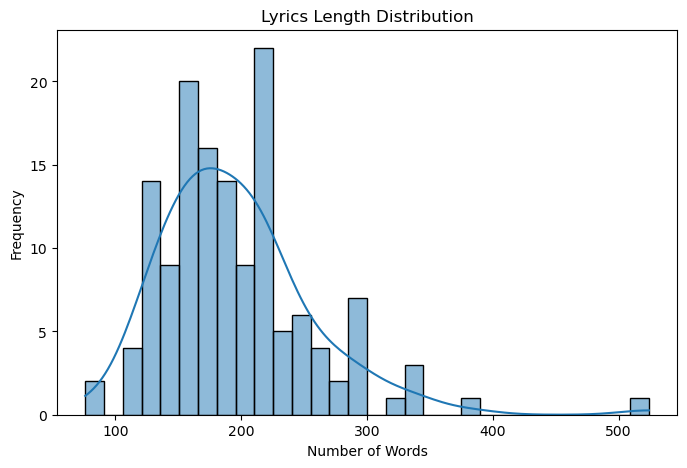

In [18]:
# Compute lyrics length for analysis
df["Lyrics Length"] = df["Cleaned Lyrics"].apply(lambda x: len(x.split()))

# Analyze most frequent lyricists and composers
lyricist_counts = Counter(df["Lyricist"].dropna())
composer_counts = Counter(df["Composer"].dropna())
distribution_counts = Counter(df["Distribution"].dropna())

# Count number of songs per album

# Identify most frequent words in lyrics
all_words = " ".join(df["Cleaned Lyrics"].dropna()).split()
word_counts = Counter(all_words)

# Find most common lyricist-composer collaborations
collaboration_counts = df.groupby(["Lyricist", "Composer","Distribution"]).size().reset_index(name="Count")
top_collaborations = collaboration_counts.sort_values(by="Count", ascending=False).head(5)

collaboration_counts_2 = df.groupby(["Lyricist", "Distribution"]).size().reset_index(name="Count")
top_collaborations_2 = collaboration_counts_2.sort_values(by="Count", ascending=False).head(5)

collaboration_counts_3 = df.groupby(["Composer", "Distribution"]).size().reset_index(name="Count")
top_collaborations_3 = collaboration_counts_3.sort_values(by="Count", ascending=False).head(5)

collaboration_counts_4 = df.groupby(["Lyricist", "Composer"]).size().reset_index(name="Count")
top_collaborations_4 = collaboration_counts_4.sort_values(by="Count", ascending=False).head(5)


# Save analysis results
df.to_excel("D:\Koleya\Deep Learning Project\Tamer_Hosny_Data.xlsx", index=False)

# Display analysis results
print("\n **Top 5 Lyricists**")
print(lyricist_counts.most_common(5))
print("\n **Top 5 Composers**")
print(composer_counts.most_common(5))
print("\n **Top 5 Distribution**")
print(distribution_counts.most_common(5))

print("\n**Top 10 Words in Lyrics**")
print(word_counts.most_common(10))

print("\n**Top 5 Lyricist-Composer-Distribution Collaborations**")
print(top_collaborations)

print("\n**Top 5 Lyricist-Distribution Collaborations**")
print(top_collaborations_2)

print("\n**Top 5 Composer-Distribution Collaborations**")
print(top_collaborations_3)

print("\n**Top 5 Lyricist-Composer Collaborations**")
print(top_collaborations_4)

# Lyrics length distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Lyrics Length"], bins=30, kde=True)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Lyrics Length Distribution")
plt.show()


## POS

In [24]:
from transformers import BertTokenizerFast
# Load the model and tokenizer
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-egy"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForTokenClassification.from_pretrained(model_name)

# Initialize the POS tagging pipeline
pos_tagger = pipeline("ner", model=model, tokenizer=tokenizer)

# Define which POS tags to keep (important tags)
IMPORTANT_TAGS = {
    'verb',      # Verbs
    'noun',      # Nouns
    'adj',       # Adjectives
    'adj_comp',  # Comparative adjectives
}

def reconstruct_words(pos_tags):
    """Reconstruct complete words from tokenized pieces"""
    reconstructed = []
    current_word = ""
    current_tag = ""
    current_score = 0
    count = 0

    for word, tag, score in pos_tags:
        # Skip low-confidence tags
        if score < 0.8:
            continue

        if word.startswith('##'):
            # This is a continuation of the previous word
            current_word += word[2:]
            current_score += score
            count += 1
        else:
            # Save the previous word if it exists
            if current_word:
                avg_score = current_score / count if count > 0 else current_score
                reconstructed.append((current_word, current_tag, avg_score))

            # Start a new word
            current_word = word
            current_tag = tag
            current_score = score
            count = 1

    # Add the last word
    if current_word:
        avg_score = current_score / count if count > 0 else current_score
        reconstructed.append((current_word, current_tag, avg_score))

    return reconstructed

def process_lyrics_with_pos(lyrics, max_length=512):
    # Tokenize into chunks without exceeding max token limit
    tokens = tokenizer(lyrics, return_offsets_mapping=True, return_tensors='pt', truncation=False)
    input_ids = tokens['input_ids'][0]  # shape: [num_tokens]

    # Split into overlapping chunks
    stride = 50  # overlap to avoid cutting words
    chunks = []
    for i in range(0, len(input_ids), max_length - stride):
        chunk_ids = input_ids[i:i + max_length]
        if len(chunk_ids) == 0:
            continue
        chunks.append(tokenizer.decode(chunk_ids, skip_special_tokens=True))

    # Collect all pos tags
    all_tags = []
    for chunk in chunks:
        try:
            chunk_tags = pos_tagger(chunk)
            all_tags.extend(chunk_tags)
        except Exception as e:
            print(f"Error processing chunk: {e}")

    # Reconstruct and filter
    pos_tags_list = [(tag['word'], tag['entity'], tag['score']) for tag in all_tags]
    reconstructed_tags = reconstruct_words(pos_tags_list)

    filtered_words = [
        word for word, tag, score in reconstructed_tags if tag in IMPORTANT_TAGS
    ]
    filtered_lyrics = ' '.join(filtered_words)

    return reconstructed_tags, filtered_lyrics


# Load the dataset
file_path = "Tamer_Hosny_Processed.xlsx"
songs = pd.read_excel(file_path)

# Apply processing to each song's lyrics
songs[['PoS Tags', 'Filtered Lyrics']] = songs['Cleaned Lyrics'].apply(
    lambda lyrics: pd.Series(process_lyrics_with_pos(lyrics))
)

# Select the columns we want to save
songs_pos = songs[['Title', 'Cleaned Lyrics', 'PoS Tags', 'Filtered Lyrics']]

# Save to Excel
output_file_path = "Tamer_Hosny_with_POS_Tags.xlsx"
songs_pos.to_excel(output_file_path, index=False)

Some weights of the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-egy were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Error processing chunk: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Error processing chunk: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1
Error processing chunk: The size of tensor a (513) must match the size of tensor b (512) at non-singleton dimension 1


## TF IDF

https://www.researchgate.net/publication/326425709_Text_Mining_Use_of_TF-IDF_to_Examine_the_Relevance_of_Words_to_Documents

c:\Users\02rad\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Successfully saved TF-IDF analysis to Tamer_with_TFIDF_Analysis.xlsx


C:\Users\02rad\AppData\Local\Temp\ipykernel_22812\1293153189.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Avg_TFIDF', y='Word', data=top_words, palette="viridis")


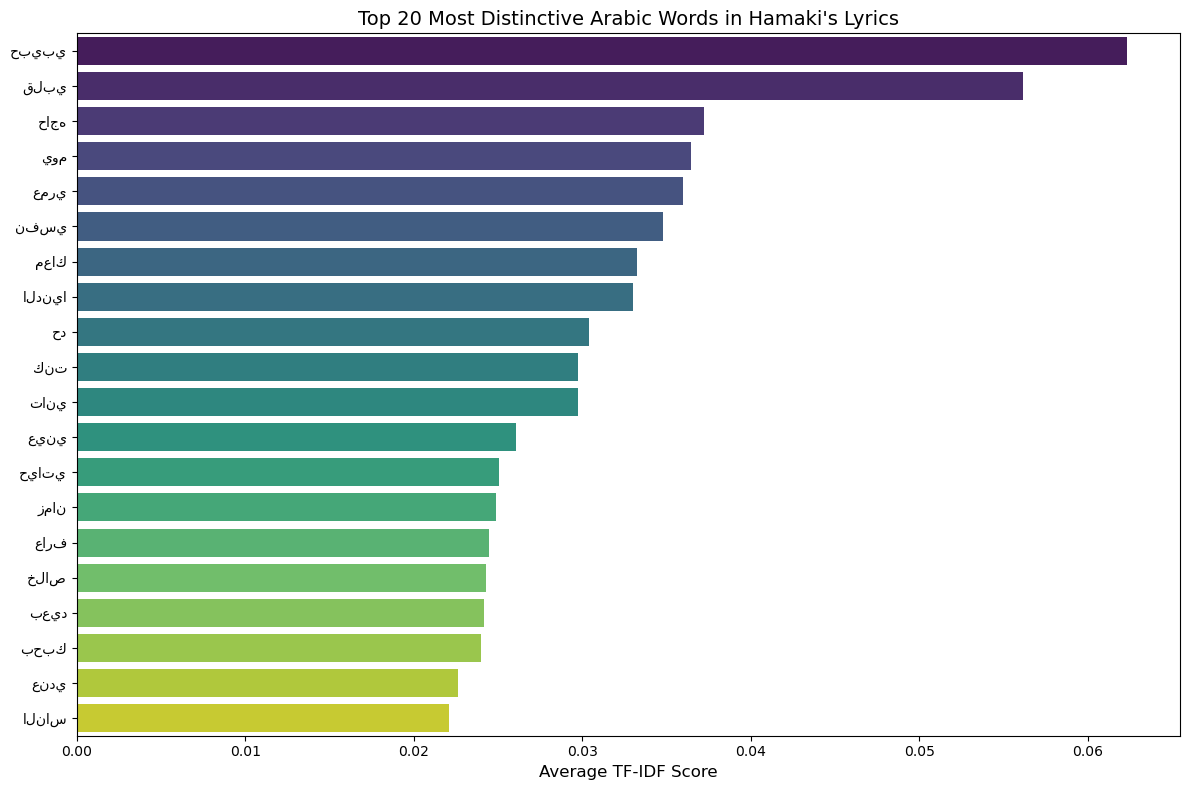

In [25]:
# Load data
df = pd.read_excel("Tamer_Hosny_with_POS_Tags.xlsx")

# 1. TF-IDF Vectorization with Arabic optimization
vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words=list(arabic_stopwords),  # Make sure this is a comprehensive Arabic list
    ngram_range=(1, 3),  # Captures Arabic multi-word expressions
    analyzer='word'      # Focus on word-level features
)

# Fit on POS-filtered lyrics
tfidf_matrix = vectorizer.fit_transform(df['Filtered Lyrics'].fillna(""))

# 2. Get Arabic feature names
feature_names = vectorizer.get_feature_names_out()

# 3. Create TF-IDF DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# 4. Extract top words for each song
def get_top_tfidf_words(row, top_n=5):
    top_indices = np.argsort(row)[::-1][:top_n]  # Indices of top N scores
    top_words = [feature_names[i] for i in top_indices if row[i] > 0]
    return ", ".join(top_words) if top_words else "None"

df['Top_TFIDF_Words'] = [get_top_tfidf_words(row) for row in tfidf_matrix.toarray()]

# 5. Add TF-IDF scores for top words (new columns)
for i in range(1, 6):
    df[f'Top_{i}_Word'] = ""
    df[f'Top_{i}_Score'] = np.nan

for idx, row in enumerate(tfidf_matrix.toarray()):
    top_indices = np.argsort(row)[::-1][:5]
    for i, pos in enumerate(top_indices):
        if row[pos] > 0:
            df.at[idx, f'Top_{i+1}_Word'] = feature_names[pos]
            df.at[idx, f'Top_{i+1}_Score'] = row[pos]

# 6. Save back to Excel (with all original data + new TF-IDF columns)
output_path = "Tamer_with_TFIDF_Analysis.xlsx"
with pd.ExcelWriter(output_path) as writer:
    df.to_excel(writer, sheet_name="Songs_with_TFIDF", index=False)

    # Additional sheet with overall word importance
    word_importance = pd.DataFrame({
        'Word': feature_names,
        'Avg_TFIDF': tfidf_matrix.mean(axis=0).A1
    }).sort_values('Avg_TFIDF', ascending=False)
    word_importance.to_excel(writer, sheet_name="Word_Importance", index=False)

print(f"Successfully saved TF-IDF analysis to {output_path}")

# 7. Visualization
plt.figure(figsize=(12, 8))
top_words = word_importance.head(20)
sns.barplot(x='Avg_TFIDF', y='Word', data=top_words, palette="viridis")
plt.title("Top 20 Most Distinctive Arabic Words in Hamaki's Lyrics", fontsize=14)
plt.xlabel("Average TF-IDF Score", fontsize=12)
plt.ylabel("")
plt.tight_layout()
plt.show()

## Clustering

In [26]:
!pip install adjustText
from adjustText import adjust_text

c:\Users\02rad\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


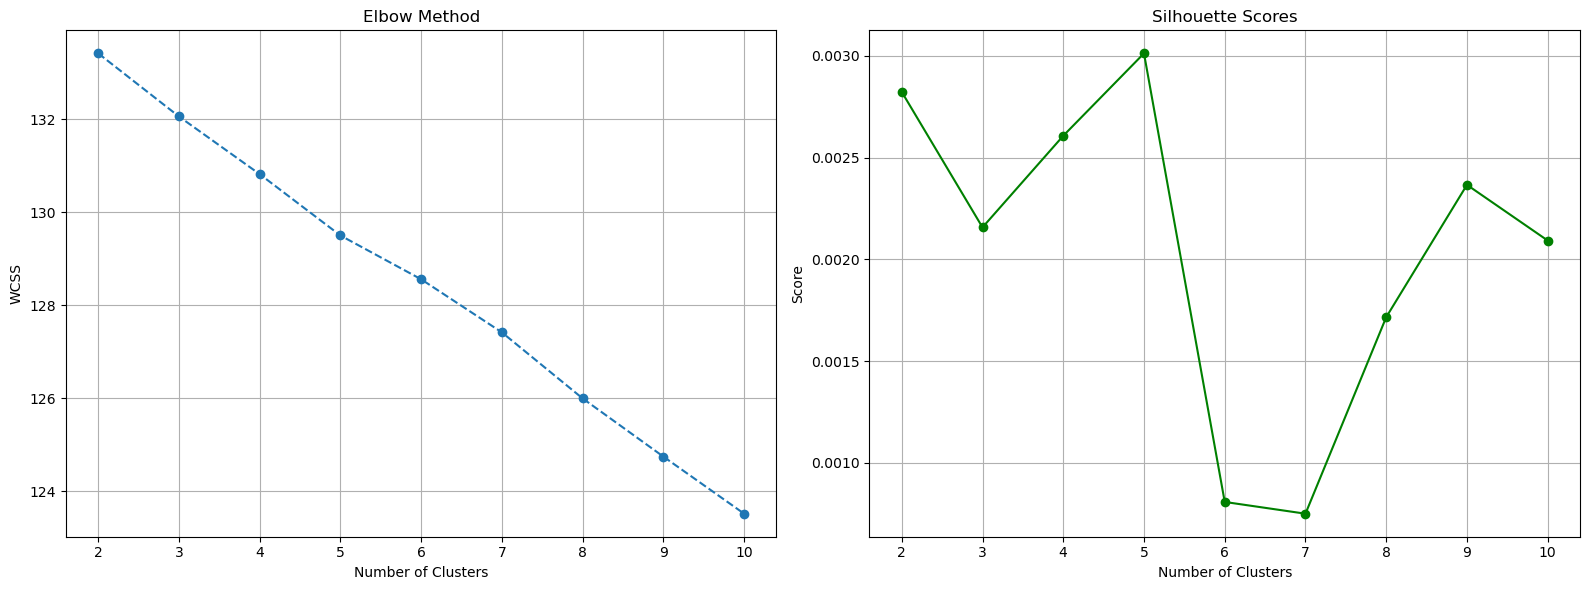

c:\Users\02rad\anaconda3\Lib\site-packages\adjustText\__init__.py:419: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  ax.figure.draw_without_rendering()
C:\Users\02rad\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


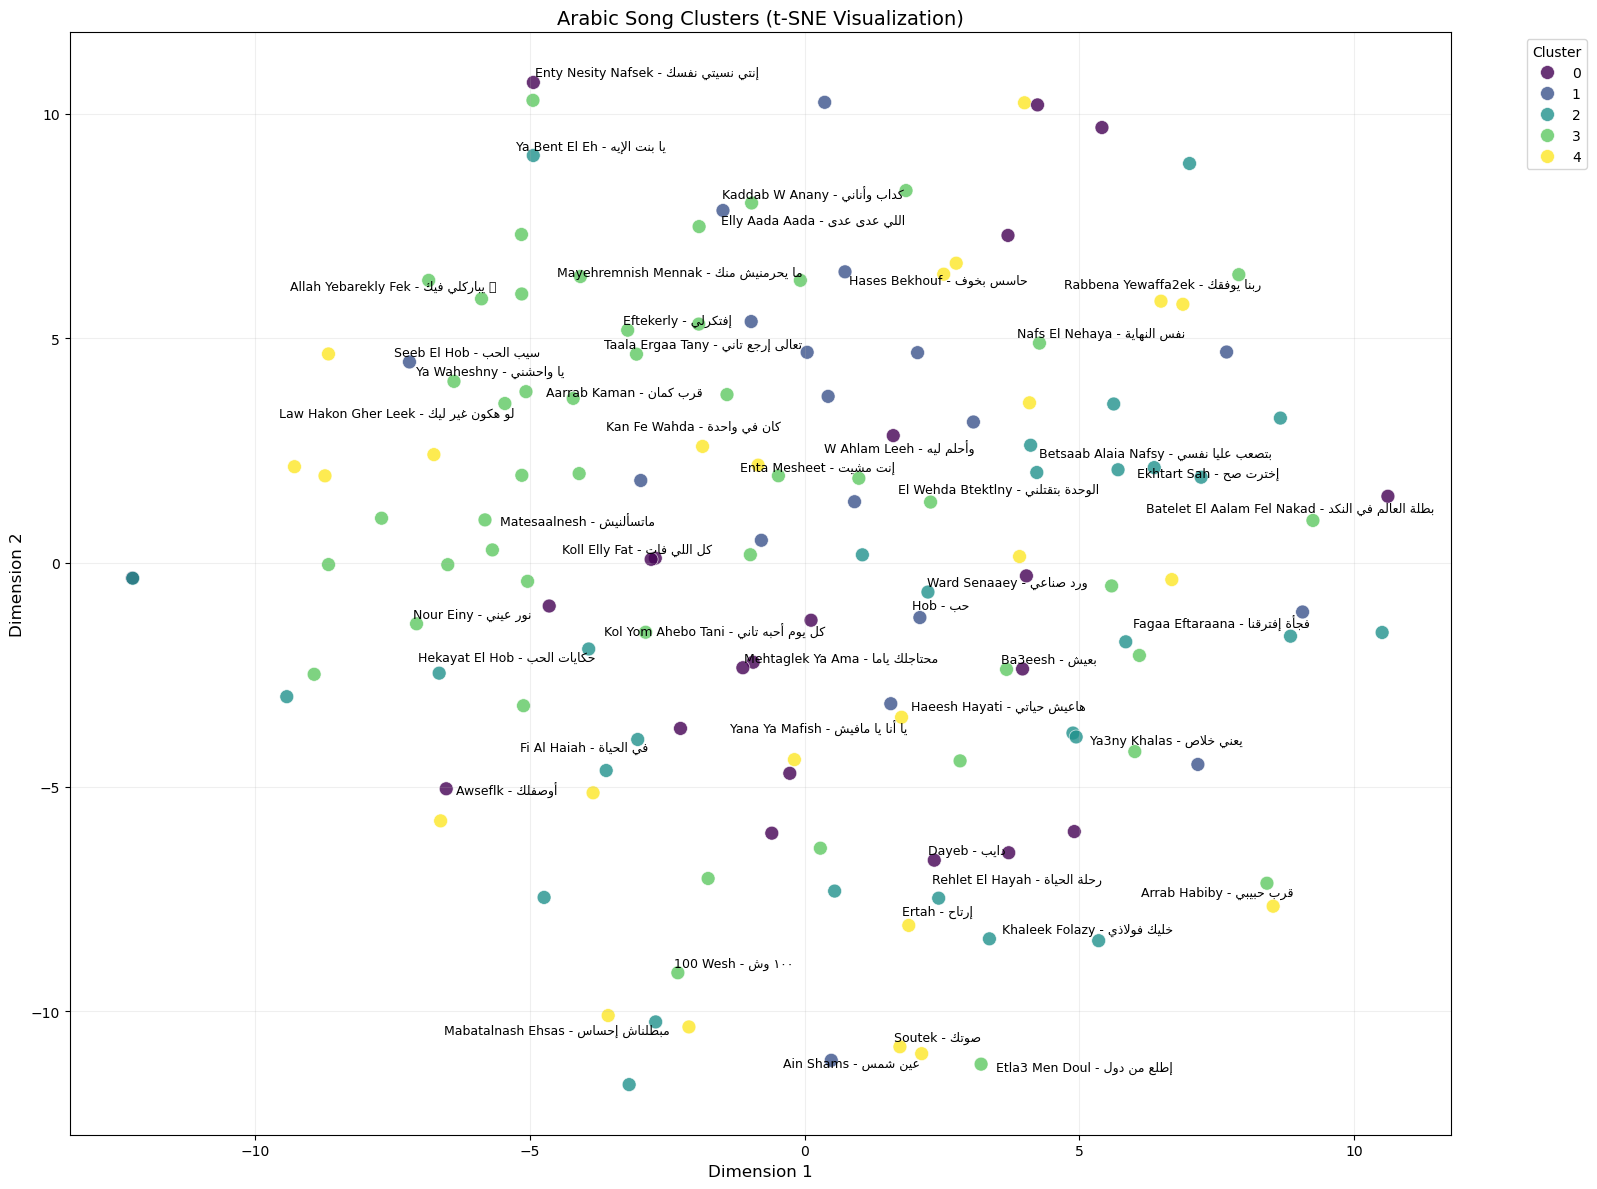

C:\Users\02rad\AppData\Local\Temp\ipykernel_22812\2574883644.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=arabic_words, palette='rocket')
C:\Users\02rad\AppData\Local\Temp\ipykernel_22812\2574883644.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=arabic_words, palette='rocket')
C:\Users\02rad\AppData\Local\Temp\ipykernel_22812\2574883644.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores), y=arabic_words, palette='rocket')
C:\Users\02rad\AppData\Local\Temp\ipykernel_22812\25

Analysis complete! Results saved to Clusters.xlsx


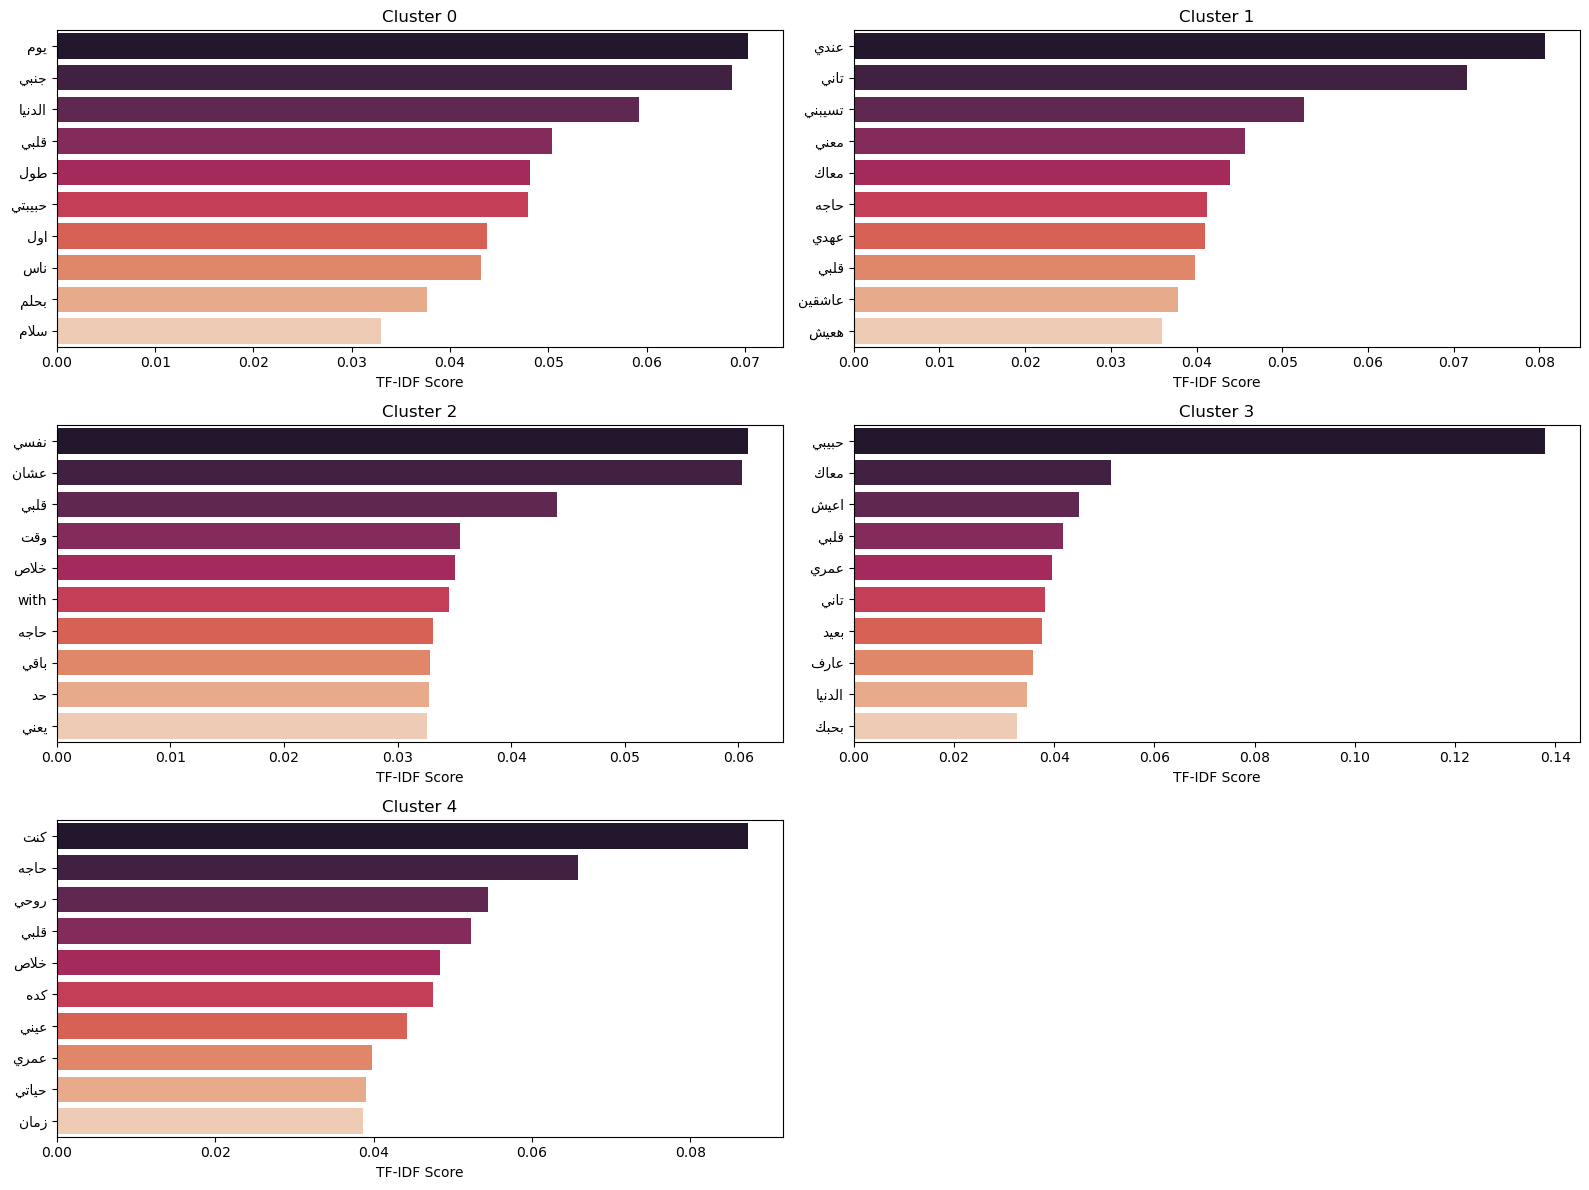

In [ ]:
from bidi.algorithm import get_display
from sklearn.manifold import TSNE

# Load data
df = pd.read_excel("Tamer_Hosny_with_POS_Tags.xlsx")

# 1. Enhanced TF-IDF Vectorization for Arabic
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words=list(arabic_stopwords),
    ngram_range=(1, 3),
    analyzer='word'
)
tfidf_matrix = vectorizer.fit_transform(df['Filtered Lyrics'].fillna(""))
feature_names = vectorizer.get_feature_names_out()

# 2. Determine Optimal Cluster Count
wcss = []
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))

# Plot elbow method and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(range(2, 11), wcss, marker='o', linestyle='--')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS')
ax1.grid()

ax2.plot(range(2, 11), silhouette_scores, marker='o', color='green')
ax2.set_title('Silhouette Scores')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Score')
ax2.grid()
plt.tight_layout()
plt.show()

# 3. Apply K-Means Clustering
optimal_clusters = 5  # Adjust based on plots
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)
df['Cluster'] = clusters

# 4. Dimensionality Reduction (t-SNE for visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tfidf_2d = tsne.fit_transform(tfidf_matrix.toarray())

# 5. Enhanced Cluster Visualization
plt.figure(figsize=(16, 12))
scatter = sns.scatterplot(
    x=tfidf_2d[:, 0],
    y=tfidf_2d[:, 1],
    hue=df['Cluster'],
    palette='viridis',
    s=100,
    alpha=0.8,
    edgecolor='w',
    linewidth=0.5
)

# Add Arabic song titles (properly displayed)
texts = []
for i in range(0, len(df), 3):  # Label every 3rd song
    reshaped_text = arabic_reshaper.reshape(df.iloc[i]['Title'])
    bidi_text = get_display(reshaped_text)
    texts.append(plt.text(
        tfidf_2d[i, 0],
        tfidf_2d[i, 1],
        bidi_text,
        fontsize=9,
        ha='center',
        va='center'
    ))
adjust_text(texts)

plt.title('Arabic Song Clusters (t-SNE Visualization)', fontsize=14)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 6. Cluster Analysis - Top Words
cluster_top_words = {}
for cluster_id in range(optimal_clusters):
    # Convert pandas boolean series to numpy array for sparse matrix indexing
    cluster_mask = (df['Cluster'] == cluster_id).values
    cluster_tfidf = tfidf_matrix[cluster_mask]

    avg_tfidf = np.asarray(cluster_tfidf.mean(axis=0)).ravel()
    top_indices = avg_tfidf.argsort()[-10:][::-1]  # Get top 10 indices

    top_words = [(feature_names[i], avg_tfidf[i])
                for i in top_indices if avg_tfidf[i] > 0]

    cluster_top_words[f'Cluster {cluster_id}'] = top_words

# 7. Bar Plot of Top Words per Cluster
plt.figure(figsize=(16, 12))
for i, (cluster, words_scores) in enumerate(cluster_top_words.items()):
    words, scores = zip(*words_scores)

    # Proper Arabic display
    arabic_words = [get_display(arabic_reshaper.reshape(w)) for w in words]

    plt.subplot(3, 2, i+1)
    sns.barplot(x=list(scores), y=arabic_words, palette='rocket')
    plt.title(f'{cluster}', fontsize=12)
    plt.xlabel('TF-IDF Score')
    plt.ylabel('')
    plt.tight_layout()

# Save Comprehensive Results
output_path = "Clusters.xlsx"
with pd.ExcelWriter(output_path) as writer:
    # Main data with clusters
    df.to_excel(writer, sheet_name="Songs", index=False)

    # TF-IDF matrix
    pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)\
      .to_excel(writer, sheet_name="TFIDF_Matrix", index=False)

    # Cluster descriptions
    cluster_desc = []
    for cluster_id, words_scores in cluster_top_words.items():
        words, _ = zip(*words_scores)
        reshaped_words = [get_display(arabic_reshaper.reshape(w)) for w in words]
        cluster_desc.append({
            'Cluster': cluster_id,
            'Top_Words': ", ".join(reshaped_words),
            'Example_Songs': ", ".join(df[df['Cluster'] == int(cluster_id.split()[-1])]['Title'].head(3))
        })
    pd.DataFrame(cluster_desc).to_excel(writer, sheet_name="Cluster_Info", index=False)

print(f"Analysis complete! Results saved to {output_path}")

## Sentiment Analysis

We use the `CAMeL-Lab/bert-base-arabic-camelbert-mix-sentiment` model from Hugging Face to classify each song's sentiment. This model is trained on both Modern Standard Arabic (MSA) and dialectal Arabic (DA), making it suitable for lyrics.

Each lyric is labeled as:
- **Positive**
- **Neutral**
- **Negative**

We apply the model to all lyrics, visualize the distribution of sentiment, and preview the results.



In [ ]:
# Load CAMeL sentiment model (MSA + Dialects)
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-mix-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Sentiment labels
labels = ["negative", "neutral", "positive"]


In [20]:
# Define prediction function
def camel_sentiment(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred = torch.argmax(probs).item()
        return labels[pred]
    except:
        return "neutral"


In [29]:
# Apply with progress bar
tqdm.tqdm.pandas()
df["Sentiment_Label"] = df["Cleaned Lyrics"].progress_apply(camel_sentiment)
df.to_excel("Hamaki_with_Arabic_Sentiment.xlsx", index=False)

100%|██████████| 140/140 [00:42<00:00,  3.31it/s]


In [30]:
df[["Cleaned Lyrics", "Sentiment_Label"]].head(10)


,Cleaned Lyrics,Sentiment_Label
0,اعزائي الغدارين اعزائي الغدارين اللي غدروا بمح...,neutral
1,لو راجعه عشان تبعدي بيني وبينها استني دي خدت ب...,neutral
2,‫ عرفت اللي فيها عينيه بان عليها يا قلبي انه م...,neutral
3,وانا جنبك حبيبي بجد مش عارف اقولك ايه معاك الو...,negative
4,قد الفراق قد الفراق اللي انت جاي بتطلبه قد الت...,neutral
5,انا لو عيني تشوف غيرك انا مش هفتحها واي كلمه ح...,positive
6,ده عيونك حلوه وطعمه عليها ضحكه تدوب والنعمه وا...,positive
7,اكلمها مابترودش عشان اقلق وبعد شويه اكلمها وان...,positive
8,قلبي اللي حبك بطل يحبك بطل يسلم بطل يتكلم بطل ...,neutral
9,يا حبيبي من حبي فيك لا هتكلم ولا اغنيلك من الي...,negative


C:\Users\02rad\AppData\Local\Temp\ipykernel_22812\3067523130.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Sentiment_Label", palette="Set2", order=["positive", "neutral", "negative"])


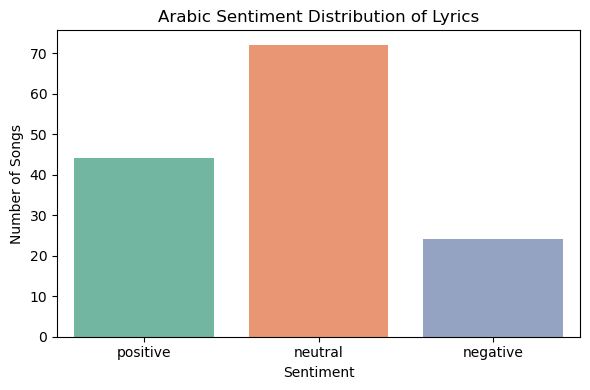

In [32]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Sentiment_Label", palette="Set2", order=["positive", "neutral", "negative"])
plt.title("Arabic Sentiment Distribution of Lyrics")
plt.xlabel("Sentiment")
plt.ylabel("Number of Songs")
plt.tight_layout()
plt.show()


100%|██████████| 140/140 [00:40<00:00,  3.48it/s]
C:\Users\02rad\AppData\Local\Temp\ipykernel_22812\2880772547.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sentiment_Label', palette='Set2',
C:\Users\02rad\AppData\Local\Temp\ipykernel_22812\2880772547.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='POS_Weighted_Sentiment', palette='Set2',



Sentiment Distribution Comparison:
Standard Analysis:
Sentiment_Label
neutral     75
positive    41
negative    24
Name: count, dtype: int64

POS-Enhanced Analysis:
POS_Weighted_Sentiment
neutral     75
positive    41
negative    24
Name: count, dtype: int64


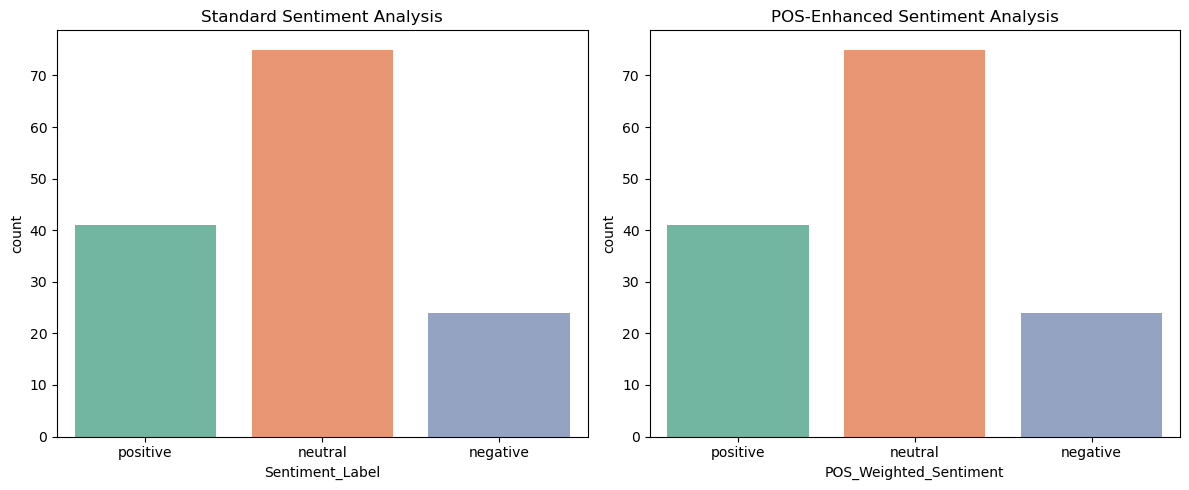

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


# Load CAMeL sentiment model
model_name = "CAMeL-Lab/bert-base-arabic-camelbert-mix-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Sentiment labels
labels = ["negative", "neutral", "positive"]

# 1. Standard Sentiment Analysis
def camel_sentiment(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            logits = model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred = torch.argmax(probs).item()
        return labels[pred], probs.numpy()[0]  # Return both label and probabilities
    except:
        return "neutral", [0.33, 0.33, 0.33]

# 2. POS-Enhanced Sentiment Analysis
def pos_weighted_sentiment(row):
    text = row['Cleaned Lyrics']
    pos_tags = row['PoS Tags']  # Assuming this contains [(word, pos_tag), ...]

    # Get base sentiment
    label, probs = camel_sentiment(text)

    # POS-based weighting
    pos_weights = {
        'adj': 1.5,    # Adjectives carry stronger sentiment
        'verb': 1.2,   # Verbs are important
        'noun': 1.0,
        'adv': 1.3     # Adverbs modify sentiment
    }

    # Calculate weight factor
    if isinstance(pos_tags, list) and len(pos_tags) > 0:
        total_weight = 0
        for _, pos in pos_tags:
            total_weight += pos_weights.get(pos, 1.0)
        avg_weight = total_weight / len(pos_tags)
        weighted_probs = probs * avg_weight
        weighted_probs = weighted_probs / weighted_probs.sum()  # Renormalize
        return labels[np.argmax(weighted_probs)]
    else:
        return label

# Apply both methods
tqdm.pandas()
df[['Sentiment_Label', 'Sentiment_Probs']] = df['Cleaned Lyrics'].progress_apply(
    lambda x: pd.Series(camel_sentiment(x)))

df['POS_Weighted_Sentiment'] = df.progress_apply(pos_weighted_sentiment, axis=1)

# Compare results
print("\nSentiment Distribution Comparison:")
print("Standard Analysis:")
print(df['Sentiment_Label'].value_counts())
print("\nPOS-Enhanced Analysis:")
print(df['POS_Weighted_Sentiment'].value_counts())

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Sentiment_Label', palette='Set2',
              order=['positive', 'neutral', 'negative'])
plt.title('Standard Sentiment Analysis')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='POS_Weighted_Sentiment', palette='Set2',
              order=['positive', 'neutral', 'negative'])
plt.title('POS-Enhanced Sentiment Analysis')
plt.tight_layout()
plt.show()

# Save results
df.to_excel("Tamer_with_Enhanced_Sentiment.xlsx", index=False)

## Emotion Detection in Arabic Lyrics (Lexicon-Based)

We detect emotional content in each lyric by mapping words to emotions using a simplified Arabic emotion lexicon (inspired by NRC Emotion Lexicon).

Each word may map to one or more of the following emotions:
- **Joy**, **Sadness**, **Anger**, **Fear**, **Trust**, **Surprise**, **Disgust**, **Anticipation**

We aggregate word-level emotions per lyric and visualize the distribution across the dataset.


In [34]:
from collections import defaultdict
import pandas as pd
import numpy as np
from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display

# Enhanced Arabic Emotion Lexicon with weights
emotion_lexicon = {
    # Love/Joy (stronger weights)
    "حب": [("love", 1.5), ("joy", 1.2)],
    "عشق": [("love", 2.0)],
    "غرام": [("love", 1.8)],
    "هيام": [("love", 1.7)],
    "شوق": [("love", 1.5), ("sadness", 1.0)],

    # Joy
    "فرح": [("joy", 1.5)],
    "سعادة": [("joy", 1.6)],
    "بهجة": [("joy", 1.4)],
    "ضحك": [("joy", 1.3)],

    # Sadness
    "حزن": [("sadness", 1.7)],
    "دموع": [("sadness", 1.8)],
    "بكاء": [("sadness", 1.9)],
    "أسى": [("sadness", 1.6)],

    # Anger
    "غضب": [("anger", 2.0)],
    "نار": [("anger", 1.8)],
    "قسوة": [("anger", 1.7)],

    # Fear
    "خوف": [("fear", 1.8)],
    "رعب": [("fear", 2.0)],

    # Surprise
    "مفاجأة": [("surprise", 1.5)],
    "صدمة": [("surprise", 1.7)],

    # Compound Emotions
    "فراق": [("sadness", 1.5), ("love", 1.2)],
    "ألم": [("sadness", 1.4), ("anger", 1.3)]
}

def detect_emotions(text):
    """Enhanced emotion detection with weighted scoring"""
    if not isinstance(text, str) or len(text.split()) < 3:  # Skip very short texts
        return {}

    emotion_scores = defaultdict(float)
    words = text.split()
    total_weight = 0

    for word in words:
        if word in emotion_lexicon:
            for emo, weight in emotion_lexicon[word]:
                emotion_scores[emo] += weight
                total_weight += weight

    # Only return results if we found significant emotional content
    if total_weight >= 1.5:  # Threshold to avoid neutral
        # Normalize scores to 0-1 range
        max_score = max(emotion_scores.values()) if emotion_scores else 1
        normalized_scores = {k: v/max_score for k, v in emotion_scores.items()}

        # Get top 3 emotions
        top_emotions = sorted(normalized_scores.items(),
                             key=lambda x: (-x[1], x[0]))[:3]

        # Format as string with scores
        return ", ".join([f"{emo}({score:.2f})" for emo, score in top_emotions])
    return "neutral"

def analyze_song(row):
    """Comprehensive analysis for each song"""
    text = row.get('Filtered Lyrics', row.get('Cleaned Lyrics', ''))
    emotions = detect_emotions(text)

    # If neutral, try with original lyrics
    if emotions == "neutral" and 'Original Lyrics' in row:
        emotions = detect_emotions(row['Original Lyrics'])

    return emotions

# Apply analysis
df["Emotion_Analysis"] = df.apply(analyze_song, axis=1)

# Create detailed emotion columns
emotion_categories = ['love', 'joy', 'sadness', 'anger', 'fear', 'surprise']
for emotion in emotion_categories:
    df[f"{emotion}_score"] = df["Emotion_Analysis"].apply(
        lambda x: float(x.split(f"{emotion}(")[1].split(")")[0]
        if f"{emotion}(" in x else 0.0)
    )

# Add emotion presence flags
for emotion in emotion_categories:
    df[f"has_{emotion}"] = (df[f"{emotion}_score"] > 0.3).astype(int)

# Add dominant emotion
def get_dominant_emotion(analysis):
    if analysis == "neutral":
        return "neutral"
    parts = analysis.split(", ")
    return parts[0].split("(")[0]

df["Dominant_Emotion"] = df["Emotion_Analysis"].apply(get_dominant_emotion)

# Enhanced output formatting
def format_arabic(text):
    try:
        return get_display(arabic_reshaper.reshape(str(text)))
    except:
        return text

# Save to Excel with Arabic support
output_path = "Emotion_Analysis.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # Main data
    df.to_excel(writer, sheet_name='Song_Emotions', index=False)

    # Create summary sheet
    summary = pd.DataFrame({
        'Statistic': ['Total Songs',
                     'Emotional Songs',
                     'Most Common Emotion',
                     'Strongest Emotion Score'],
        'Value': [len(df),
                 len(df[df['Dominant_Emotion'] != 'neutral']),
                 df['Dominant_Emotion'].mode()[0],
                 df[[f"{e}_score" for e in emotion_categories]].max().max()]
    })
    summary.to_excel(writer, sheet_name='Summary', index=False)

print(f"Analysis complete. Saved to {output_path}")
print("\nSample Results:")
print(df[["Title", "Emotion_Analysis", "Dominant_Emotion"]].head(10))

Analysis complete. Saved to Emotion_Analysis.xlsx

Sample Results:
                                    Title       Emotion_Analysis  \
0                       100 Wesh - ١٠٠ وش                neutral   
1                    180 Darga - ١٨٠ درجة                neutral   
2        3reft Elly Feha - عرفت اللي فيها                neutral   
3                 Aarrab Kaman - قرب كمان  love(1.00), joy(0.80)   
4                 Ad El Foraq - قد الفراق                neutral   
5                  Afalt Alby - قفلت قلبي                neutral   
6                     Ain Shams - عين شمس                neutral   
7                       Akalemha - أكلمها                neutral   
8        Alby Elly Habbak - قلبي اللي حبك                neutral   
9  Allah Yebarekly Fek - الله يباركلي فيك  love(1.00), joy(0.80)   

  Dominant_Emotion  
0          neutral  
1          neutral  
2          neutral  
3             love  
4          neutral  
5          neutral  
6          neutral  
7          neutr

<ipython-input-40-02d8f46dc1a4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


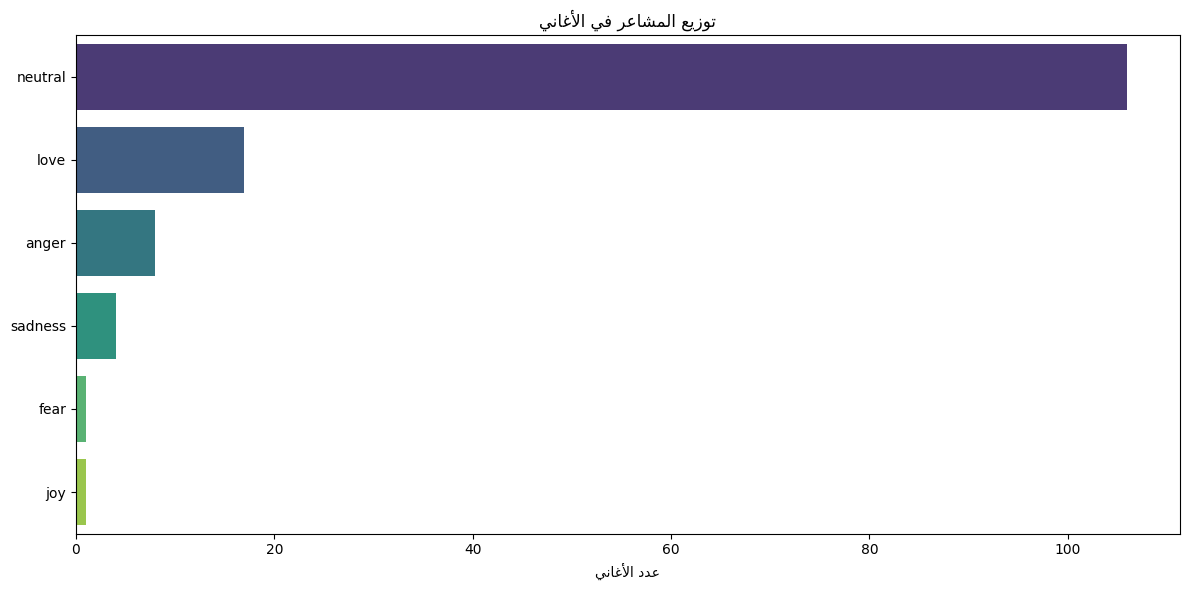

In [ ]:
# Prepare Arabic text display
def arabic_text(text):
    return get_display(arabic_reshaper.reshape(text))

# Plot emotion distribution
plt.figure(figsize=(12, 6))
emotion_counts = df['Dominant_Emotion'].value_counts()
sns.barplot(
    x=emotion_counts.values,
    y=[arabic_text(e) for e in emotion_counts.index],
    palette='viridis'
)
plt.title(arabic_text('توزيع المشاعر في الأغاني'))
plt.xlabel(arabic_text('عدد الأغاني'))
plt.ylabel('')
plt.tight_layout()
plt.show()